In [39]:
# data, system tools
import pandas as pd
import numpy as np
import os
import glob
import itertools

# multiprocessing
import multiprocessing as mp
from functools import partial

# stats
from statsmodels.stats import outliers_influence
import statsmodels.stats.multitest as multi
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statannot
import scipy
import scipy.stats
from scipy.stats import chi2

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [40]:
## Fitting functions
def make_empty_model_df(ROIs,
                        metrics=('location',), 
                        statistics=('X', 'Y', 'Z'), 
                        predictors=('Age', 'Age2', 'sex', 'Age*sex', 'Age2*sex')):
    
    possible_predictors = ['Age', 'Age2', 'sex', 'Age:sex', 'Age2:sex']
    all_models = pd.DataFrame(list(itertools.product(*[[False, True] for x in range(len(possible_predictors))])), columns=possible_predictors)

    def make_iv_string(x):
        ivs = ' + '.join(np.array(x.index)[x.values])
        if ivs == '':
            ivs = '1'
        return ivs
    ivs = all_models.apply(lambda x: make_iv_string(x), axis=1).values
    
    all_combs = list(itertools.product(ROIs, metrics, statistics, ivs))
    model_df = pd.DataFrame(all_combs, columns=['ROI', 'metric', 'Statistic', 'ivs'])
    model_df['model'] = np.nan
    model_df['result'] = np.nan
    model_df['BIC'] = np.nan
    model_df['rsquared'] = np.nan
    return model_df, all_combs

def fit_mp(to_fit, model_df, data_df, 
           dep_var_name = 'value',
           predictor_columns = ('Age', 'Age2', 'sex'),
           exclude_high_cook=False):
    
    roi, metric, statistic, ivs = to_fit
    
    # find index of this model
    idx_modeldf = (model_df.metric == metric) & (model_df.ROI == roi) & (model_df.ivs == ivs) & (model_df.Statistic == statistic)
    
    # find index of this data
    idx_datadf = (data_df.Intensity == metric) & (data_df.ROI == roi) & (data_df.Statistic == statistic)
    
    # make a quick copy, for ease
    get_columns = [dep_var_name] + list(predictor_columns)
    if exclude_high_cook:
        this_df = data_df.loc[idx_datadf,  get_columns + ['high_cook']].copy()
        this_df = this_df.loc[this_df['high_cook']==False]
    else:
        this_df = data_df.loc[idx_datadf, get_columns].copy()
    
    if pd.isnull(this_df[dep_var_name]).sum() > 0:
        print('WARNING: {} {} {} has missing values'.format(roi, metric, statistic))
    this_df = this_df.loc[~pd.isnull(this_df[dep_var_name])]
    
    # fit
    formula = dep_var_name + ' ~ ' + ivs
    model = smf.ols(formula, this_df)
    results = model.fit()
    
    # fit quality
    model_df.loc[idx_modeldf, 'model'] = model
    model_df.loc[idx_modeldf, 'result'] = results
    model_df.loc[idx_modeldf, 'BIC'] = results.bic
    model_df.loc[idx_modeldf, 'rsquared'] = results.rsquared
    
#     # Bayesian fitting in R
#     if ivs != '1':
#         bf_obj = bayesfactor.lmBF(ro.r('as.formula(' + formula + ')'), data=this_df)
#         model_df.loc[idx_modeldf, 'bf'] = bayesfactor.extractBF(bf_obj)['bf'].values[0]    
    
    return model_df.loc[idx_modeldf]

In [3]:
def plot_influence(df, winning_model_df, influence_type='index', 
                         f=None, ax=None, shape=(4,4)):
    if ax is None:
        f, ax = plt.subplots(shape[0], shape[1], sharey=True, figsize=(15,15))
        ax = ax.ravel()
        
    for i, roi in enumerate(df.ROI.unique()):
        # plot winning model
        model_df_idx = (winning_model_df.ROI == roi) #& (winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)
        if model_df_idx.sum() > 0:
            result = winning_model_df.loc[model_df_idx, 'result'].values[0]
            if influence_type == 'index':
                _ = outliers_influence.OLSInfluence(result).plot_index(ax=ax[i], title=roi)
            elif influence_type == 'influence':
                _ = outliers_influence.OLSInfluence(result).plot_influence(ax=ax[i], title=roi)
    f.tight_layout()
    f.subplots_adjust(top=0.95, right=.9)
    return f, ax

def plot_residuals(df, winning_model_df, model_df, studentized=False,
                         f=None, ax=None, shape=(4,4)):
    if ax is None:
        f, ax = plt.subplots(shape[0], shape[1], sharey=True, figsize=(15,15))
        ax = ax.ravel()
        
    for i, roi in enumerate(df.ROI.unique()):
        # plot winning model
        ax[i].axhline(0)
        ax[i].set_xlabel('Age')
        ax[i].set_ylabel('Residual')
        ax[i].set_title(roi)

        model_df_idx = (winning_model_df.ROI == roi) #& (winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)
        if model_df_idx.sum() > 0:
            result = winning_model_df.loc[model_df_idx, 'result'].values[0]
            if studentized:
                y_vals = outliers_influence.OLSInfluence(result).resid_studentized
            else:
                y_vals = outliers_influence.OLSInfluence(result).resid
            
            # look up corresponding age values. If the *winning* model doesn't have age as a predictor, 
            # look ages up from a (non-winning) model that does have age
            if 'Age' in result._results.model.data.orig_exog.columns:
                x_vals = result._results.model.data.orig_exog['Age']
            else:
                model_df_idx2 = (model_df.ROI == roi) & (model_df.ivs == 'Age') #& (model_df.qMRI == intensity) & (model_df.Statistic == statistic) & (model_df.ivs == 'Age')
                result_with_age = model_df.loc[model_df_idx2, 'result'].values[0]
                x_vals = result_with_age._results.model.data.orig_exog['Age']
            
            # plot
            _ = ax[i].plot(x_vals, y_vals, '.')

#    f.set_size_inches(15, 15)
    f.tight_layout()
    f.subplots_adjust(top=0.95, right=.9)

def plot_model_fit(df, winning_model_df, statistic='', intensity='', f=None, ax=None, shape=(4,4),
                   dep_var_name='Value'):
    if ax is None:
        f, ax = plt.subplots(shape[0], shape[1], sharey=False, figsize=(15,15))
        ax = ax.ravel()
    
    age_range = np.arange(19, 81)
    predict_df_0 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 0})
    predict_df_1 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 1})
    
    for i, roi in enumerate(df.ROI.unique()):
        idx = (df.ROI == roi) & (df.Intensity == intensity) & (df.Statistic == statistic)

        this_df = df.loc[idx, [dep_var_name] + ['Age', 'Age2', 'sex']]
#        this_df['is_outlier'] = 0
        if 'high_cook' in df.columns:
            this_df['is_outlier'] = df.loc[idx, 'high_cook'].values.copy().astype(int)
        else:
            this_df['is_outlier'] = 0
# ax[i].axhline(y=0, linestyle='--', color='black')

        ## non-outliers
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), dep_var_name], '.', c='red', label='F data')
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), dep_var_name], '.', c='blue', label='M data')

        ## outliers
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), dep_var_name], 'x', c='red', label='F outlier')
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), dep_var_name], 'x', c='blue', label='M outlier')
        ax[i].set_ylabel(intensity)
        ax[i].set_xlabel('Age')
        ax[i].set_title(roi)

        # plot winning model
        model_df_idx = (winning_model_df.ROI == roi) & (winning_model_df.metric == intensity) & (winning_model_df.Statistic == statistic)
        if model_df_idx.sum() > 0:
            result = winning_model_df.loc[model_df_idx, 'result'].values[0]

            predicted_0 = result.predict(predict_df_0) # sex = 0
            predicted_1 = result.predict(predict_df_1) # sex = 1

            ax[i].plot(age_range, predicted_0, '-', label='F model', c='red')
            ax[i].plot(age_range, predicted_1, '-', label='M model', c='blue')

            # add text indicating the winning model. Apply a "trick" plot an empty line with the winning model as the label
            tmp = ax[i].plot(np.NaN, np.NaN, '-', color='none', label=winning_model_df.loc[model_df_idx, 'ivs'].values[0])
            handles, labels = ax[i].get_legend_handles_labels()
            ax[i].legend(handles[-1:], labels[-1:])

    # add a legend
    handles, labels = ax[i].get_legend_handles_labels()
    f.legend(handles[:-1], labels[:-1], loc='right')   # skip first (dots) and last (label) index
    f.suptitle('{} {}'.format(statistic, intensity), fontsize=24)
            
    # add shared axis labels
    f.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel("Age")

    # increase size, tight layout so labels dont overlap, add some space at the top & left so title fits
#    f.set_size_inches(15, 15)
    f.tight_layout()
    f.subplots_adjust(top=0.95, right=.9)

    return f, ax

# plot_model_fit(df.loc[(df.Intensity == 'iron') & (df.Statistic == 'median')],
#                winning_model_df.loc[(winning_model_df.qMRI == 'iron') & (winning_model_df.Statistic == 'median')],
#                intensity='iron', statistic='median')

# plot_residuals(df.loc[(df.Intensity == 'iron') & (df.Statistic == 'median')],
#                winning_model_df.loc[(winning_model_df.qMRI == 'iron') & (winning_model_df.Statistic == 'median')],
#                model_df.loc[(model_df.qMRI == 'iron') & (model_df.Statistic == 'median')],
#                intensity='iron', statistic='median', studentized=True)

def make_plot_mp(combination, df, winning_model_df, model_df, dep_var_name='Value',
                 fn_template='../figures_location/location_axis-{}.pdf'):
    intensity, statistic = combination
    print(intensity)
    n_rows = 8
    figsize=(15,25)
    
    if fn_template is not None:
        pdf = PdfPages(fn_template.format(statistic))
    f, ax = plt.subplots(n_rows,4, sharey=False, figsize=figsize)
    ax = ax.ravel()

    # select from dataframes
    this_df = df.loc[(df.Intensity == intensity) & (df.Statistic == statistic)]
    this_winning_model_df = winning_model_df.loc[(winning_model_df.metric == intensity) & (winning_model_df.Statistic == statistic)]
    this_model_df = model_df.loc[(model_df.metric == intensity) & (model_df.Statistic == statistic)]

    plot_model_fit(df=this_df,
                   winning_model_df=this_winning_model_df, dep_var_name=dep_var_name,
                   intensity=intensity, statistic=statistic, f=f, ax=ax)
    if fn_template is not None:
        pdf.savefig(f)

    for plot_type in ['index', 'influence']:
        f, ax = plt.subplots(n_rows,4, sharey=True, figsize=figsize)
        ax = ax.ravel()
        plot_influence(df=this_df, winning_model_df=this_winning_model_df, influence_type=plot_type, f=f, ax=ax)
        if fn_template is not None:
            pdf.savefig(f)

    for studentized in [False, True]:
        f, ax = plt.subplots(n_rows,4, sharey=True, figsize=figsize)
        ax = ax.ravel()
        plot_residuals(df=this_df, 
                       winning_model_df=this_winning_model_df, 
                       model_df=this_model_df, studentized=studentized,
                       f=f, ax=ax)
        if fn_template is not None:
                pdf.savefig(f)

    if fn_template is not None:
        pdf.savefig(f)
        pdf.close()
        plt.close('all')  ## force close, don't show in-line

## Location - load data

In [4]:
ahead_long = pd.read_csv('../data/final_data/AHEAD_and_CRUISE_and_ICV-combined-long.csv')
ahead_long.head()

ahead_long.loc[ahead_long['ROI'] == 'fx', 'hemisphere'] = 'X'
ahead_long.loc[ahead_long['ROI'] == 'Cerebellum', 'hemisphere'] = 'X'

In [5]:
all_csvs = sorted(glob.glob('../data/source_data/ahead-31struct-qmri2fcm-brain*.csv'))
data = []
for csv in all_csvs:
    this_csv = pd.read_csv(csv)
    this_csv['Intensity'] = csv.split('-')[-2]
    data.append(this_csv)
    
data = pd.concat(data)
col_names = ['STR L', 'STR R',
             'STN L', 'STN R',
             'SN L', 'SN R',
             'RN L', 'RN R',
             'GPi L', 'GPi R',
             'GPe L', 'GPe R',
             'THA L', 'THA R',
             'LV L', 'LV R',
             '3V', '4V',
             'AMG L', 'AMG R',
             'ic L', 'ic R',
             'VTA L', 'VTA R',
             'fx',
             'PAG L', 'PAG R',
             'PPN L', 'PPN R',
             'CL L', 'CL R']
# col_names_orig = list(pd.read_csv('./old_data_not_denoised/ahead-35struct-simple-statistics-edited.csv').columns[3:-1])
# col_names = [x for x in col_names_orig if not 'ICO ' in x and not 'SCO ' in x]  # ICO & SCO were dropped due to poor segmentation performance

In [6]:
demo = pd.read_csv('../data/source_data/ahead_demographics.csv', sep=';')
demo = demo.loc[pd.notnull(demo['ScanName'])]
demo['Segmentation'] = demo['ScanName'].apply(lambda x: 'sub-' + x[-3:])
demo.head()

,ScanName,Sexe,Group,Age,Segmentation
0,Subcortex_0000,f,1F,22.0,sub-000
1,Subcortex_0001,m,1M,23.0,sub-001
2,Subcortex_0002,f,1F,25.0,sub-002
3,Subcortex_0003,f,1F,23.0,sub-003
4,Subcortex_0004,f,1F,23.0,sub-004


In [7]:
data.columns = ['Measure', 'Segmentation', 'Template', 'Intensity'] + col_names
data['Segmentation'] = data['Segmentation'].apply(lambda x: x.split('_')[0])
data = data.loc[data['Segmentation'] != 'sub-070']  # subject was dropped due to data quality issues
del data['Template']

# merge subcortex data with demographics
data = pd.merge(data, demo[['Sexe', 'Age', 'Segmentation']], on='Segmentation')
data = data.sort_values(['Measure', 'Segmentation', 'Intensity'])
data.head()

# coerce to float
for col in col_names:
    data[col] = pd.to_numeric(data[col], errors='coerce')


In [8]:
data_long = data.melt(id_vars=['Segmentation', 'Intensity', 'Measure', 'Sexe', 'Age'], var_name='ROI')
data_long['ROI2'] = data_long['ROI'].str.split(' ').apply(lambda x: x[0])
data_long['hemisphere'] = data_long['ROI'].str.split(' ').apply(lambda x: x[1] if len(x)>1 else 'X')
data_long['tissue_type'] = data_long['ROI2'].map({'STR': 'GM',
                                                  'STN': 'GM',
                                                  'SN': 'GM',
                                                  'RN': 'GM',
                                                  'GPi': 'GM',
                                                  'GPe': 'GM',
                                                  'THA': 'GM',
                                                  'LV': 'CSF',
                                                  '3V': 'CSF',
                                                  '4V': 'CSF',
                                                  'AMG': 'GM',
                                                  'ic': 'WM',
                                                  'VTA': 'GM',
                                                  'fx': 'WM',
                                                  'PAG': 'GM',
                                                  'PPN': 'GM',
                                                  'ICO': 'GM',
                                                  'SCO': 'GM',
                                                  'CL': 'GM',
                                                  'Cortex': 'GM',
                                                  'Cerebellum': 'GM'})
data_long.head()

# pretend these singular structures are in left hemisphere for code compatibility
data_long.loc[data_long['ROI'] == 'fx', 'hemisphere'] = 'X'
data_long.loc[data_long['ROI'] == 'Cerebellum', 'hemisphere'] = 'X'
data_long.loc[data_long['ROI'] == '3V', 'hemisphere'] = 'X'
data_long.loc[data_long['ROI'] == '4V', 'hemisphere'] = 'X'

In [9]:
location_data = data_long.loc[(data_long.Intensity.isin(['location']))]
location_data['Statistic'] = location_data['Measure'].apply(lambda x: x[-1])
location_data.head()

,Segmentation,Intensity,Measure,Sexe,Age,ROI,value,ROI2,hemisphere,tissue_type,Statistic
0,sub-000,location,CenterOfMassX,f,22.0,STR L,155.07576,STR,L,GM,X
1,sub-001,location,CenterOfMassX,m,23.0,STR L,154.84969,STR,L,GM,X
2,sub-002,location,CenterOfMassX,f,25.0,STR L,151.86940,STR,L,GM,X
3,sub-003,location,CenterOfMassX,f,23.0,STR L,151.72502,STR,L,GM,X
4,sub-004,location,CenterOfMassX,f,23.0,STR L,152.82648,STR,L,GM,X


In [10]:
## img for affine
import nilearn
import nilearn.image
import nibabel as nib
nii = nib.load('/home/pilou/Projects/Ahead-Database/Automated-Parcellation/affine_head/sub-000_brain-affine_ants-def0.nii.gz')
nii.affine

array([[  0.5,   0. ,   0. , -98. ],
       [  0. ,  -0.5,   0. ,  98.5],
       [  0. ,   0. ,   0.5, -72. ],
       [  0. ,   0. ,   0. ,   1. ]])

In [11]:
location_wide = location_data.pivot_table(values='value', index=['Segmentation', 'Intensity', 'Sexe', 'Age', 'ROI', 'ROI2', 'hemisphere', 'tissue_type'], columns='Statistic')
location_wide['X_mni'] = location_wide.apply(lambda x: nilearn.image.coord_transform(x['X'], x['Y'], x['Z'], affine=nii.affine)[0], axis=1)
location_wide['Y_mni'] = location_wide.apply(lambda x: nilearn.image.coord_transform(x['X'], x['Y'], x['Z'], affine=nii.affine)[1], axis=1)
location_wide['Z_mni'] = location_wide.apply(lambda x: nilearn.image.coord_transform(x['X'], x['Y'], x['Z'], affine=nii.affine)[2], axis=1)

location_wide['X_mni_abs'] = location_wide['X_mni']
location_wide = location_wide.reset_index()
location_wide.loc[location_wide['hemisphere'] == 'L','X_mni_abs'] = location_wide.loc[location_wide['hemisphere'] == 'L','X_mni'].abs()
location_wide

Statistic,Segmentation,Intensity,Sexe,Age,ROI,ROI2,hemisphere,tissue_type,X,Y,Z,X_mni,Y_mni,Z_mni,X_mni_abs
0,sub-000,location,f,22.0,3V,3V,X,CSF,197.020320,245.39587,151.789660,0.510160,-24.197935,3.894830,0.510160
1,sub-000,location,f,22.0,4V,4V,X,CSF,195.164250,280.41135,67.471200,-0.417875,-41.705675,-38.264400,-0.417875
2,sub-000,location,f,22.0,AMG L,AMG,L,GM,142.672780,206.39632,96.608086,-26.663610,-4.698160,-23.695957,26.663610
3,sub-000,location,f,22.0,AMG R,AMG,R,GM,242.906660,203.40826,95.834465,23.453330,-3.204130,-24.082767,23.453330
4,sub-000,location,f,22.0,CL L,CL,L,GM,126.690025,202.94330,143.222720,-34.654987,-2.971650,-0.388640,34.654987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,sub-109,location,f,23.0,VTA L,VTA,L,GM,189.196120,233.70865,114.649740,-3.401940,-18.354325,-14.675130,3.401940
3251,sub-109,location,f,23.0,VTA R,VTA,R,GM,205.185040,233.36218,116.582780,4.592520,-18.181090,-13.708610,4.592520
3252,sub-109,location,f,23.0,fx,fx,X,WM,191.272640,233.49260,164.311950,-2.363680,-18.246300,10.155975,-2.363680
3253,sub-109,location,f,23.0,ic L,ic,L,WM,159.718050,208.78447,164.471900,-18.140975,-5.892235,10.235950,18.140975


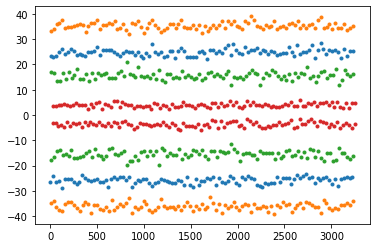

In [12]:
# check to see mirroring
tmp = location_wide.reset_index()
plt.plot(tmp.loc[tmp['ROI2'] == 'AMG', 'X_mni'], '.')
plt.plot(tmp.loc[tmp['ROI2'] == 'CL', 'X_mni'], '.')
plt.plot(tmp.loc[tmp['ROI2'] == 'LV', 'X_mni'], '.')
plt.plot(tmp.loc[tmp['ROI2'] == 'VTA', 'X_mni'], '.')

# that seems good

In [13]:
location_long = location_wide.melt(id_vars=['Segmentation', 'Intensity', 'Sexe', 'Age', 'ROI', 'ROI2', 'hemisphere', 'tissue_type'])
location_long.to_csv('../data/final_data/center_of_mass.csv', index=False)

## PCA

One could argue that the axes of 'left-right', 'inferior-superior', 'posterior-anterior' are arbitrary and the brain doesn't care much about them, so model comparison per one these three axes doesn't make sense. Here, we tried to first do a PCA on the location data to identify the three principal axes of variance, and then transform the data to these new axes, fit age-related change models & do model comparison in PCA space, and then inverse transform the data and model predictions back to the original axes. This works but the predictions for the across-age changes are highly similar with the original 'left-right', 'inferior-superior', 'posterior-anterior' axes. Hence, we still have this part in the code below, but later collapse across hemispheres and then simply use the nominal three axes.

In [14]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import  StandardScaler

In [15]:
location_wide = location_long.pivot_table(values='value', index=['Segmentation', 'Intensity', 'Sexe', 'Age', 'ROI', 'ROI2', 'hemisphere', 'tissue_type'], columns='Statistic').reset_index()

def get_pca_axis(x):
    ss = StandardScaler()
    x_transformed = ss.fit_transform(x)
    pca = PCA(3)
    y = pca.fit_transform(x_transformed)
    out = pd.DataFrame(y, index=x.index, columns=['PCA1', 'PCA2', 'PCA3'])
    out['scaler'] = ss
    out['pca_model'] = pca
    return out
out = location_wide.groupby(['ROI'])[['X', 'Y', 'Z']].apply(get_pca_axis)
location_wide = pd.concat([location_wide, out], axis=1)

In [16]:
location_long = location_wide.melt(id_vars=['Segmentation', 'Intensity', 'Sexe', 'Age', 'ROI', 'ROI2', 'hemisphere', 'tissue_type', 'pca_model', 'scaler'], 
                                   value_vars=['X', 'Y', 'Z', 'PCA1', 'PCA2', 'PCA3',
                                               'X_mni', 'Y_mni', 'Z_mni', 'X_mni_abs'], var_name='Statistic')
location_data = location_long.copy()

## Location models

In [17]:
location_data['sex'] = (location_data['Sexe'] == 'm').astype(int)
location_data['Age2'] = location_data['Age']**2

In [18]:
model_df, all_combinations = make_empty_model_df(ROIs=location_data.ROI.unique(), statistics=('X', 'Y', 'Z', 'PCA1', 'PCA2', 'PCA3'))

n_cores = 20
with mp.Pool(n_cores) as p:
    print("Fitting all models with {} cores".format(n_cores))
    output = p.map(partial(fit_mp, model_df=model_df.copy(), data_df=location_data.copy()), all_combinations)
    
model_df = pd.concat(output)
model_df.head()

model_df['is_winner_BIC'] = model_df.groupby(['ROI', 'Statistic'])[['BIC']].apply(lambda x: x == x.min())
winning_model_df = model_df.loc[model_df['is_winner_BIC']]
display(winning_model_df.groupby(['Statistic'])['ivs'].value_counts())

Fitting all models with 20 cores


Statistic  ivs                            
PCA1       Age:sex                             8
           Age2 + Age:sex                      7
           1                                   3
           Age2 + sex                          3
           Age                                 2
           Age + sex                           2
           Age2 + Age2:sex                     2
           Age2:sex                            2
           Age + Age2:sex                      1
           Age + Age:sex                       1
PCA2       1                                   8
           Age2                                6
           Age                                 5
           Age2 + sex                          2
           Age2:sex                            2
           Age:sex                             2
           Age + Age2:sex                      1
           Age + Age:sex                       1
           Age2 + Age:sex                      1
           Age:sex + Age2:

In [19]:
# winning_model_df.to_pickle('../data/location_models_twohemispheres.pkl')

In [20]:
# plot & save
sns.set_context('notebook')

with mp.Pool(6) as p:
    p.map(partial(make_plot_mp, df=location_data.copy(), dep_var_name='value',
                  winning_model_df=winning_model_df, model_df=model_df,
                 fn_template='../figures_location/location_brain_axis-{}.pdf'), 
          list(itertools.product(('location',), ('X', 'Y', 'Z', 'PCA1', 'PCA2', 'PCA3'))))

location
location
location
location
location
location


In [21]:
# plot the PCA models after an inverse transform back to the 'normal' axes

intensity = 'location'
#statistic = 'X'
df = location_data.copy()
winning_model_df=winning_model_df
model_df=model_df
dep_var_name='value'

age_range = np.arange(19, 81)
predict_df_0 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 0})
predict_df_1 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 1})

for dim_n, statistic in enumerate(['X', 'Y', 'Z']):
    pdf = PdfPages('../figures_location/location_axis-{}_transformed.pdf'.format(statistic))
    f, ax = plt.subplots(8, 4, sharey=False, figsize=(15,25))
    ax = ax.ravel()
    
    for i,roi in enumerate(df.ROI.unique()):
        idx = (df.ROI == roi) & (df.Intensity == intensity) & (df.Statistic == statistic)

        this_df = df.loc[idx, [dep_var_name] + ['Age', 'Age2', 'sex']]
        if 'high_cook' in df.columns:
            this_df['is_outlier'] = df.loc[idx, 'high_cook'].values.copy().astype(int)
        else:
            this_df['is_outlier'] = 0
#         ax[i].axhline(y=0, linestyle='--', color='black')

        ## non-outliers
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), dep_var_name], '.', c='red', label='F data')
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), dep_var_name], '.', c='blue', label='M data')

        ## outliers
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), dep_var_name], 'x', c='red', label='F outlier')
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), dep_var_name], 'x', c='blue', label='M outlier')
        ax[i].set_ylabel('')
        ax[i].set_xlabel('Age')
        ax[i].set_title(roi)

        # Predictions for all 3 winnign models on PCA axes
        model_df_idx1 = (winning_model_df.ROI == roi) & (winning_model_df.metric == intensity) & (winning_model_df.Statistic == 'PCA1')
        model_df_idx2 = (winning_model_df.ROI == roi) & (winning_model_df.metric == intensity) & (winning_model_df.Statistic == 'PCA2')
        model_df_idx3 = (winning_model_df.ROI == roi) & (winning_model_df.metric == intensity) & (winning_model_df.Statistic == 'PCA3')

        # predctions
        result1 = winning_model_df.loc[model_df_idx1, 'result'].values[0]
        result2 = winning_model_df.loc[model_df_idx2, 'result'].values[0]
        result3 = winning_model_df.loc[model_df_idx3, 'result'].values[0]

        predicted_0_1 = result1.predict(predict_df_0) # sex = 0
        predicted_1_1 = result1.predict(predict_df_1) # sex = 1
        predicted_0_2 = result2.predict(predict_df_0) # sex = 0
        predicted_1_2 = result2.predict(predict_df_1) # sex = 1
        predicted_0_3 = result3.predict(predict_df_0) # sex = 0
        predicted_1_3 = result3.predict(predict_df_1) # sex = 1

        # inverse transform
        pca = location_data.loc[location_data.ROI == roi, 'pca_model'].iloc[0]
        ss = location_data.loc[location_data.ROI == roi, 'scaler'].iloc[0]
        predicted_0_xyz = ss.inverse_transform(pca.inverse_transform(np.vstack([predicted_0_1, predicted_0_2, predicted_0_3]).T))
        predicted_1_xyz = ss.inverse_transform(pca.inverse_transform(np.vstack([predicted_1_1, predicted_1_2, predicted_1_3]).T))

        # these are our predictions in X, Y, Z-space
        ax[i].plot(age_range, predicted_0_xyz[:,dim_n], '-', label='F model', c='red')
        ax[i].plot(age_range, predicted_1_xyz[:,dim_n], '-', label='M model', c='blue')

    # add a legend
    handles, labels = ax[i].get_legend_handles_labels()
    f.legend(handles[:-1], labels[:-1], loc='right')   # skip first (dots) and last (label) index
    f.suptitle('{} {}'.format(statistic, intensity), fontsize=24)
            
    # add shared axis labels
    f.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel("Age")

    # increase size, tight layout so labels dont overlap, add some space at the top & left so title fits
    f.tight_layout()
    f.subplots_adjust(top=0.95, right=.9)
    pdf.savefig(f)
    pdf.close()
    plt.close('all')

In [22]:
# def plot_model_fit_inverse_transform_pca(df, winning_model_df, statistic='', intensity='', f=None, ax=None, 
#                                          shape=(4,4),
#                                          dep_var_name='Value'):
#     if ax is None:
#         f, ax = plt.subplots(shape[0], shape[1], sharey=False, figsize=(15,15))
#         ax = ax.ravel()
    
#     age_range = np.arange(19, 81)
#     predict_df_0 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 0})
#     predict_df_1 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 1})
    
#     for i, roi in enumerate(df.ROI.unique()):
#         idx = (df.ROI == roi) & (df.Intensity == intensity) & (df.Statistic == statistic)

#         this_df = df.loc[idx, [dep_var_name] + ['Age', 'Age2', 'sex']]
# #        this_df['is_outlier'] = 0
#         if 'high_cook' in df.columns:
#             this_df['is_outlier'] = df.loc[idx, 'high_cook'].values.copy().astype(int)
#         else:
#             this_df['is_outlier'] = 0
#         ax[i].axhline(y=0, linestyle='--', color='black')

#         ## non-outliers
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), dep_var_name], '.', c='red', label='F data')
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), dep_var_name], '.', c='blue', label='M data')

#         ## outliers
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), dep_var_name], 'x', c='red', label='F outlier')
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), dep_var_name], 'x', c='blue', label='M outlier')
#         ax[i].set_ylabel(intensity)
#         ax[i].set_xlabel('Age')
#         ax[i].set_title(roi)

#         # plot winning model
#         model_df_idx = (winning_model_df.ROI == roi) & (winning_model_df.metric == intensity) & (winning_model_df.Statistic == statistic)
#         if model_df_idx.sum() > 0:
#             result = winning_model_df.loc[model_df_idx, 'result'].values[0]

#             predicted_0 = result.predict(predict_df_0) # sex = 0
#             predicted_1 = result.predict(predict_df_1) # sex = 1

#             ax[i].plot(age_range, predicted_0, '-', label='F model', c='red')
#             ax[i].plot(age_range, predicted_1, '-', label='M model', c='blue')

#             # add text indicating the winning model. Apply a "trick" plot an empty line with the winning model as the label
#             tmp = ax[i].plot(np.NaN, np.NaN, '-', color='none', label=winning_model_df.loc[model_df_idx, 'ivs'].values[0])
#             handles, labels = ax[i].get_legend_handles_labels()
#             ax[i].legend(handles[-1:], labels[-1:])

#     # add a legend
#     handles, labels = ax[i].get_legend_handles_labels()
#     f.legend(handles[:-1], labels[:-1], loc='right')   # skip first (dots) and last (label) index
#     f.suptitle('{} {}'.format(statistic, intensity), fontsize=24)
            
#     # add shared axis labels
#     f.add_subplot(111, frame_on=False)
#     plt.tick_params(labelcolor="none", bottom=False, left=False)
#     plt.xlabel("Age")

#     # increase size, tight layout so labels dont overlap, add some space at the top & left so title fits
# #    f.set_size_inches(15, 15)
#     f.tight_layout()
#     f.subplots_adjust(top=0.95, right=.9)

#     return f, ax


## collapse across hemispheres

In [23]:
location_data_collapsed = location_long.copy()
location_data_collapsed['sex'] = (location_data_collapsed['Sexe'] == 'm').astype(int)
location_data_collapsed = location_data_collapsed.groupby(['Segmentation', 'Age', 'sex', 'Statistic', 'ROI2', 'Intensity'])['value'].mean().reset_index()
location_data_collapsed['ROI'] = location_data_collapsed['ROI2']
location_data_collapsed['Age2'] = location_data_collapsed['Age']**2

In [24]:
model_df, all_combinations = make_empty_model_df(ROIs=location_data_collapsed.ROI.unique(), statistics=('X_mni_abs', 'Y_mni', 'Z_mni'))

n_cores = 20
with mp.Pool(n_cores) as p:
    print("Fitting all models with {} cores".format(n_cores))
    output = p.map(partial(fit_mp, model_df=model_df.copy(), data_df=location_data_collapsed.copy()), all_combinations)
    
model_df = pd.concat(output)
model_df.head()

model_df['is_winner_BIC'] = model_df.groupby(['ROI', 'Statistic'])[['BIC']].apply(lambda x: x == x.min())
winning_model_df = model_df.loc[model_df['is_winner_BIC']]
display(winning_model_df.groupby(['Statistic'])['ivs'].value_counts())

Fitting all models with 20 cores


Statistic  ivs                            
X_mni_abs  Age2                                7
           1                                   3
           Age                                 3
           Age + Age2 + Age:sex + Age2:sex     1
           Age2 + sex                          1
           Age:sex                             1
           sex                                 1
Y_mni      1                                  12
           Age2                                2
           Age                                 1
           Age2:sex                            1
           Age:sex                             1
Z_mni      Age + Age:sex                       5
           Age:sex                             4
           Age2:sex                            3
           Age2 + Age:sex                      2
           Age2 + sex                          2
           Age + Age2:sex                      1
Name: ivs, dtype: int64

In [25]:
# plot & save
sns.set_context('notebook')

with mp.Pool(6) as p:
    p.map(partial(make_plot_mp, df=location_data_collapsed.copy(), dep_var_name='value',
                  winning_model_df=winning_model_df, model_df=model_df,
                 fn_template='../figures_location/location_brain_acrosshemi_axis-{}.pdf'), 
          list(itertools.product(('location',), ('X_mni_abs', 'Y_mni', 'Z_mni'))))

location
location
location


## Remove high cook's, mahalanobis

In [26]:
# winning_model_df['outlier_influence'] = winning_model_df['result'].apply(lambda x: outliers_influence.OLSInfluence(x))

# location_data_collapsed['cooks_d'] = winning_model_df['outlier_influence'].apply(lambda x: x.cooks_distance[0]).sum()
# location_data_collapsed['high_cook'] = location_data_collapsed['cooks_d'] > 0.2

# # Redo
# model_df, all_combinations = make_empty_model_df(ROIs=location_data_collapsed.ROI.unique(), statistics=('X_mni_abs', 'Y_mni', 'Z_mni'))

# n_cores = 20
# with mp.Pool(n_cores) as p:
#     print("Fitting all models with {} cores".format(n_cores))
#     output = p.map(partial(fit_mp, model_df=model_df.copy(), data_df=location_data_collapsed.copy(), exclude_high_cook=True), all_combinations)
    
# model_df = pd.concat(output)
# model_df.head()

# model_df['is_winner_BIC'] = model_df.groupby(['ROI', 'Statistic'])[['BIC']].apply(lambda x: x == x.min())
# winning_model_df = model_df.loc[model_df['is_winner_BIC']]
# display(winning_model_df.groupby(['Statistic'])['ivs'].value_counts())

# # plot & save
# with mp.Pool(6) as p:
#     p.map(partial(make_plot_mp, df=location_data_collapsed.copy(), dep_var_name='value',
#                   winning_model_df=winning_model_df, model_df=model_df, 
#                  fn_template='../figures_location/location_brain_acrosshemi_axis-{}_excl-high-cooks.pdf'), 
#           list(itertools.product(('location',), ('X_mni_abs', 'Y_mni', 'Z_mni'))))

In [27]:
def mahalanobis(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return pd.DataFrame(data={'mahalanobis_d': mahal.diagonal(),
                              'mahalanobis_p': 1-chi2.cdf(mahal.diagonal(), 1)}, index=x.index)  # chi-square distribution

out = location_data_collapsed.groupby(['ROI', 'Intensity', 'Statistic']).apply(lambda x: mahalanobis(x[['Age', 'value']], data=x[['Age', 'value']]))
location_data_collapsed['mahalanobis_d'] = out['mahalanobis_d']
location_data_collapsed['mahalanobis_p'] = out['mahalanobis_p']
location_data_collapsed['mahalanobis_exclude'] = location_data_collapsed['mahalanobis_p'] < 0.001

In [28]:
for i in range(4):  # 4 is arbitrary, but sufficient to identify all outliers
    # find Cook's distances per subject
    winning_model_df['outlier_influence'] = winning_model_df['result'].apply(lambda x: outliers_influence.OLSInfluence(x))    
    location_data_collapsed[f'cooks_d_{i}'] = winning_model_df['outlier_influence'].apply(lambda x: x.cooks_distance[0]).sum()
    # 
        
    if (location_data_collapsed[f'cooks_d_{i}'] > 0.2).sum() == 0:  #no more outliers anywhere, we can stop
        break
    
    if i == 0:
        # Remove high cook's
        location_data_collapsed[f'remove_{i}'] = location_data_collapsed[f'cooks_d_{i}'].copy() > 0.2
    else:
        idx = pd.isnull(location_data_collapsed[f'cooks_d_{i}'])
        location_data_collapsed.loc[idx, f'cooks_d_{i}'] = location_data_collapsed.loc[idx, f'cooks_d_{i-1}']  # null values (ie observation not in current model)? -> use previous value
        # Did removing the subs with high cook's change the winning model?
        # yes? -> keep removing them. No? -> don't remove them.
        for indx, row_ in winning_model_df.iterrows():
            if not row_[f'new_winning_model_{i-1}']:
                idx = (location_data_collapsed.Statistic == row_['Statistic']) & (location_data_collapsed.ROI2 == row_['ROI'])
                if i == 1:
                    # if this is the first update, set it to false
                    location_data_collapsed.loc[idx, f'remove_{i-1}'] = False
                else:
                    # else, set it to whatever it was before on the previous iteration
                    location_data_collapsed.loc[idx, f'remove_{i-1}'] = location_data_collapsed.loc[idx, f'remove_{i-2}'].copy()

        # remove this iteration if it was remove on previous iteration OR if the subject has a high cook's on this iteration
        location_data_collapsed[f'remove_{i}'] = location_data_collapsed[f'remove_{i-1}'].copy() | (location_data_collapsed[f'cooks_d_{i}'].copy() > 0.2)
    
    # Mark for removal
    location_data_collapsed['high_cook'] = location_data_collapsed[f'remove_{i}'].copy() | location_data_collapsed['mahalanobis_exclude']
    
    # Fit again
    model_df, all_combinations = make_empty_model_df(ROIs=location_data_collapsed.ROI.unique(), statistics=('X_mni_abs', 'Y_mni', 'Z_mni'))

    n_cores = 20
    with mp.Pool(n_cores) as p:
        print("Fitting all models with {} cores".format(n_cores))
        output = p.map(partial(fit_mp, model_df=model_df.copy(), data_df=location_data_collapsed.copy(), exclude_high_cook=True), all_combinations)

#     with mp.Pool(n_cores) as p:
#         print("Fitting all models with {} cores".format(n_cores))
#         output = p.map(partial(fit_mp, model_df=model_df.copy(), data_df=qMRI_data_collapsed.copy(), 
#                                exclude_high_cook=True), all_combinations)

# model_df = pd.concat(output)
# model_df.head()

# model_df['is_winner_BIC'] = model_df.groupby(['ROI', 'Statistic'])[['BIC']].apply(lambda x: x == x.min())
# winning_model_df = model_df.loc[model_df['is_winner_BIC']]
# display(winning_model_df.groupby(['Statistic'])['ivs'].value_counts())


    model_df = pd.concat(output)

    winning_model_df_prev = winning_model_df.copy()  # make a copy of previous winning models for comparison
    model_df['is_winner_BIC'] = model_df.groupby(['ROI', 'Statistic'])[['BIC']].apply(lambda x: x == x.min())
    winning_model_df = model_df.loc[model_df['is_winner_BIC']]
    winning_model_df[f'ivs_{i-1}'] = winning_model_df_prev['ivs']
    winning_model_df[f'new_winning_model_{i}'] = winning_model_df[f'ivs_{i-1}'] != winning_model_df['ivs']
    
    # Plot
    with mp.Pool(6) as p:
        p.map(partial(make_plot_mp, df=location_data_collapsed.copy(), dep_var_name='value',
                      winning_model_df=winning_model_df, model_df=model_df, 
                     fn_template=f'../figures_location/location_brain_acrosshemi_axis-{{}}_excl-high-cooks-{i}.pdf'), 
              list(itertools.product(('location',), ('X_mni_abs', 'Y_mni', 'Z_mni'))))
    
# display(winning_model_df.groupby(['qMRI', 'Statistic'])['ivs'].value_counts())

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Fitting all models with 20 cores


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


location
location
location
Fitting all models with 20 cores
location
location
location
Fitting all models with 20 cores
location
location
location


In [29]:
winning_model_df.to_pickle('./app/subcortex-app/data/winning_models/location_models_acrosshemispheres.pkl')

In [30]:
def get_mean_change(result, relative=True):
    age_range = np.arange(19, 76)
    predict_df_0 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 0})
    predict_df_1 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 1})

    all_predictions_1 = np.abs(np.diff(result.predict(predict_df_1))).sum() * np.sign(np.diff(result.predict(predict_df_1)).sum())
    if relative:
        all_predictions_1 /= result.predict(predict_df_1)[0]
    all_predictions_0 = np.abs(np.diff(result.predict(predict_df_0))).sum() * np.sign(np.diff(result.predict(predict_df_0)).sum())
    if relative:
        all_predictions_0 /= result.predict(predict_df_0)[0]
    return np.mean([all_predictions_0, all_predictions_1])

winning_model_df['mean_derivative'] = winning_model_df['result'].apply(get_mean_change, relative=False)
winning_model_df

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ROI,metric,Statistic,ivs,model,result,BIC,rsquared,is_winner_BIC,ivs_1,new_winning_model_2,outlier_influence,mean_derivative
4,3V,location,X_mni_abs,sex,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,208.840608,7.690890e-02,True,sex,False,<statsmodels.stats.outliers_influence.OLSInflu...,0.000000
40,3V,location,Y_mni,Age2,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,472.018061,6.234210e-02,True,Age2,False,<statsmodels.stats.outliers_influence.OLSInflu...,1.718222
76,3V,location,Z_mni,Age2 + sex,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,485.049644,4.902303e-01,True,Age2 + sex,False,<statsmodels.stats.outliers_influence.OLSInflu...,-5.075133
98,4V,location,X_mni_abs,Age:sex,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,312.427821,4.747197e-02,True,Age:sex,False,<statsmodels.stats.outliers_influence.OLSInflu...,0.254395
128,4V,location,Y_mni,1,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,463.665346,0.000000e+00,True,1,False,<statsmodels.stats.outliers_influence.OLSInflu...,0.000000
161,4V,location,Z_mni,Age2:sex,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,476.933713,2.149214e-01,True,Age2:sex,False,<statsmodels.stats.outliers_influence.OLSInflu...,-2.156386
200,AMG,location,X_mni_abs,Age2,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,269.807397,1.438857e-01,True,Age2,False,<statsmodels.stats.outliers_influence.OLSInflu...,1.021428
224,AMG,location,Y_mni,1,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,368.919635,0.000000e+00,True,1,False,<statsmodels.stats.outliers_influence.OLSInflu...,0.000000
274,AMG,location,Z_mni,Age + Age:sex,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,436.618008,1.767122e-01,True,Age + Age:sex,False,<statsmodels.stats.outliers_influence.OLSInflu...,-2.204365
316,CL,location,X_mni_abs,Age + Age2 + sex,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,316.092834,2.349378e-01,True,Age + Age2 + sex,False,<statsmodels.stats.outliers_influence.OLSInflu...,2.106253


In [31]:
summary_table = winning_model_df.loc[winning_model_df.Statistic.isin(['X_mni_abs', 'Y_mni', 'Z_mni'])].sort_values(['Statistic', 'ROI', 'metric']).set_index(['Statistic', 'ROI', 'metric'])[['mean_derivative']]#.to_csv('./model_comparison_overview.csv')
final_table = summary_table.reset_index()[['metric', 'ROI', 'Statistic', 'mean_derivative']].pivot_table(index='ROI', columns=['metric', 'Statistic']).round(3)
final_table.to_pickle('../data/interim_data/summary_table_location.pkl')

Excluded 30 of 5355 datapoints (0.00560%) based on Mahalanobis
Excluded 48 of 5355 datapoints (0.00896%) based on Cooks


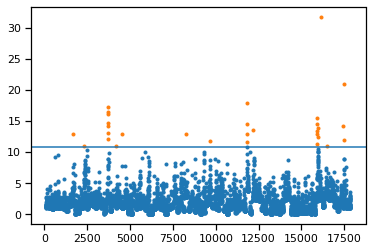

In [32]:
used_data_points = (location_data_collapsed.Statistic.isin(['X_mni_abs', 'Y_mni', 'Z_mni']))
plt.plot(location_data_collapsed.loc[(used_data_points) & ~(location_data_collapsed.mahalanobis_exclude), 'mahalanobis_d'], '.')
plt.plot(location_data_collapsed.loc[(used_data_points) & (location_data_collapsed.mahalanobis_exclude), 'mahalanobis_d'], '.')
plt.axhline(chi2.ppf(.999, 1))


#print('Excluded {} of {} datapoints ({}%)'.format(location_data_collapsed.loc[used_data_points].mahalanobis_exclude.sum(), used_data_points.sum(), location_data_collapsed.loc[used_data_points].mahalanobis_exclude.mean()))  

print('Excluded {} of {} datapoints ({:.5f}%) based on Mahalanobis\nExcluded {} of {} datapoints ({:.5f}%) based on Cooks'.format(location_data_collapsed.loc[used_data_points].mahalanobis_exclude.sum(), used_data_points.sum(), location_data_collapsed.loc[used_data_points].mahalanobis_exclude.mean(),
     location_data_collapsed.loc[used_data_points].high_cook.sum(), used_data_points.sum(), location_data_collapsed.loc[used_data_points].high_cook.mean()))
# 0.72% of all data points
#location_data_collapsed.loc[used_data_points].mahalanobis_exclude.sum()   # 0.72% of all data points

In [33]:
# Total excluded based on mahalanobis:
(171 + 30) / (23730 + 5355)  # 0.69% of data points, average with the qMRI models

# additional excluded based on cook's:
(35 + 18) / (23730 + 5355)

0.0018222451435447825

### Cook's

## bootstrapping

In [34]:
winning_model_df = pd.read_pickle('./app/subcortex-app/data/winning_models/location_models_acrosshemispheres.pkl')

In [35]:
def check_ages_are_good(ages):
    if (ages < 30).sum() < 10:
        return False
    if ((ages >= 30) & (ages < 40)).sum() < 10:
        return False
    if ((ages >= 40) & (ages < 50)).sum() < 10:
        return False
    if ((ages >= 50) & (ages < 60)).sum() < 10:
        return False
    if ((ages >= 60) & (ages < 70)).sum() < 10:
        return False
    if (ages >= 70).sum() < 10:
        return False
    return True

def get_balanced_sample(data):
    return pd.concat([data.loc[data.Age<30].sample(frac=1, replace=True),
                       data.loc[(data.Age>=30) & (data.Age<40)].sample(frac=1, replace=True),
                       data.loc[(data.Age>=40) & (data.Age<50)].sample(frac=1, replace=True),
                       data.loc[(data.Age>=50) & (data.Age<60)].sample(frac=1, replace=True),
                       data.loc[(data.Age>=60) & (data.Age<70)].sample(frac=1, replace=True),
                       data.loc[(data.Age>=70)].sample(frac=1, replace=True)])


In [36]:
def do_bootstrap(model, n_iter=1000, enforce_balanced_ages=True):
    outcomes = {'absolute_mean_change': np.empty(n_iter)
                }
    data = model.data.frame.copy()  # extract data from model
    formula = model.formula
    if not ('Age' in formula or 'Age2' in formula):
        outcomes['absolute_mean_change'] = [0,0,0,0]
    else:
        for i in range(n_iter):
    #    for i in range(n_iter):
    #         if i % 100 == 0:
    #             print(i)
            if enforce_balanced_ages:
                this_sample = get_balanced_sample(data)
            else:
                this_sample = data.sample(frac=1, replace=True)

            new_model = smf.ols(formula, this_sample)
            results = new_model.fit()

            outcomes['absolute_mean_change'][i] = get_mean_change(results, relative=False)
    return outcomes

def get_SE_CI(outcomes):
    out = {}
    for key,val in outcomes.items():
        if key != 'n_samples_rejected':
            out[key] = {'CI': [np.percentile(val, 2.5), np.percentile(val, 97.5)],
                        'SE': np.std(val),
                        'mean': np.mean(val),
                        'median': np.median(val)}
    return out

def get_errors(i, winning_model_df, n_iter=10000, enforce_balanced_ages=True):
    model = winning_model_df.iloc[i]['model']
    
    new_row = winning_model_df.iloc[i].copy()
    new_row['bootstrap_results'] = get_SE_CI(do_bootstrap(model, n_iter=n_iter, enforce_balanced_ages=enforce_balanced_ages))
    return new_row

In [37]:
# import joblib
# from functools import partial
# from joblib import delayed

# for n_iter in [100, 1000, 10000]:
#     all_out = joblib.Parallel(n_jobs=10, verbose=1)(delayed(get_errors)(i, winning_model_df=winning_model_df, n_iter=n_iter, enforce_balanced_ages=True) for i in range(winning_model_df.shape[0]))
#     all_bootstrapped_res = pd.DataFrame(all_out)
#     all_bootstrapped_res.to_pickle(f'../data/bootstraps/all_bootstrapped_location_data_n={n_iter}_balanced.pkl')

In [ ]:
import joblib
from functools import partial
from joblib import delayed

for n_iter in [100, 10000]:
    all_out = joblib.Parallel(n_jobs=10, verbose=1)(delayed(get_errors)(i, winning_model_df=winning_model_df, n_iter=n_iter, enforce_balanced_ages=False) for i in range(winning_model_df.shape[0]))
    all_bootstrapped_res = pd.DataFrame(all_out)
    all_bootstrapped_res.to_pickle(f'../data/bootstraps/all_bootstrapped_location_data_n={n_iter}.pkl')

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   10.5s
